# Simulate Battery for Solar Plant

## Introduction

Notebook to simulate batteries of different sizes for an existing solar plant. 

On sunny days your PV system usually feeds the excess energy that you cannot use at home to the grid, while you have to draw energy from the grid on cloudy days (and at night). Your own consumption can be increased by adding a battery to your PV system. The size of the battery (and inverter) heavily depends on the setup of you PV system and epecially on your personal power consumption profile.

Modern energy meters provide all the information needed to simulate different batteries and inverters for your personal needs. This software uses this data to find out which combination best fits your needs and assists you in your buying decision. The script simulates batteries of different sizes which are charged, when power is fed to the grid and discharged, when power is drawn from the grid.

## Settings

In [69]:
# Maximum charging and discharging power of battery / inverter combination in W
max_discharging_power = 5000
max_charging_power = 5000

# Set sizes (in kWh) and names of batteries of to be simulated
battery_sizes = [5, 7, 10, 13]
battery_names = ["5", "7", "10", "13"]

## Import Data

In [70]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Load data
Replace data file with your own data. The `sample_data.csv` is only used to explain the data structure. The cells below were run using a larger data file.

In [71]:
all_data = pd.read_csv('sample_data.csv')
all_data.head()

,Unnamed: 0,timestamp,power
0,0,2024-03-09 17:07:18,-316.0
1,1,2024-03-09 17:22:18,-240.0
2,2,2024-03-09 17:37:18,-124.0
3,3,2024-03-09 17:52:18,-40.0
4,4,2024-03-09 18:07:18,186.0


## Calculate Power and Energy usable by Battery

In [72]:
df = pd.DataFrame.from_records(all_data, columns = ['timestamp', 'power'])

# calculate column power_battery. 
# power in this column is limited by max_discharging_power and max_charging_power of the inverter
df['power_battery'] = df['power']
df.loc[df['power'] > max_discharging_power, 'power_battery'] = max_discharging_power
df.loc[df['power'] < -max_charging_power, 'power_battery'] = -max_charging_power

# calculate excess power, not usable by battery due to above limitation of min/max (dis)charging power.
# This fraction is always fed or drawn to/from the grid
df['power_excess'] = df['power'] - df['power_battery']

# Calculate time difference to previous row
df['time'] = pd.to_datetime(df['timestamp'], format='ISO8601')
df['time_period'] = df['time'].diff()
df['time_period'] = df['time_period'] /np.timedelta64(1,'s')

# Calculate Energy usable by battery for charging / discharging in kWh
df['energy_battery'] = - df['time_period'] * df['power_battery'] / (60 * 60 * 1000)
df['energy_battery'] = df['energy_battery'].fillna(0)
df.head()

# Calculate excess energy that was not considered during charge / discharge of the batteries
# because it the total power was above / below the maximum charge / discharge power
df['energy_inverter_excess'] = - df['time_period'] * df['power_excess'] / (60 * 60 * 1000)
df['energy_inverter_excess'] = df['energy_inverter_excess'].fillna(0)

/var/folders/jz/h19nwtvs27j_1xj4rzfgl8500000gn/T/ipykernel_10023/564330700.py:1: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(all_data, columns = ['timestamp', 'power'])


## Define Function to Simulate Battery

In [73]:
# Function to simulate a battery of size battery_size. 
# df contains energy that could be charged or discharged at each time.
def simulate_battery(df, battery_size):
    print('Simulating battery of size ', str(battery_size), ' kWh.')
    last_energy_in_battery = 0 
    last_total_energy_provided_by_battery = 0 

    energy_in_battery = []
    energy_excess_to_grid = []
    energy_provided_by_battery = []
    total_energy_provided_by_battery = []

    # go through all rows and check if energy can be charged or discharged to battery
    for row in df.iterrows():
        # Add energy of this row to battery and check if battery is either full or empty. 
        # In this case, set battery state to battery_size or zero. 
        # Copy excess energy, not taken by battery to this_energy_excess_to_grid
        this_energy_in_battery =  row[1]['energy_battery'] + last_energy_in_battery 
        # If battery is full, copy excess to this_energy_excess_to_grid
        if this_energy_in_battery > battery_size:
            this_energy_excess_to_grid = this_energy_in_battery - battery_size
            this_energy_in_battery = battery_size
        # If battery is empty, copy excess to this_energy_excess_to_grid
        elif this_energy_in_battery < 0:
            this_energy_excess_to_grid = this_energy_in_battery
            this_energy_in_battery = 0
        # If battery is not full or empty, set this_energy_excess_to_grid to zero
        else:
            this_energy_excess_to_grid = 0
        
        # Append data to lists
        energy_in_battery.append( this_energy_in_battery )
        energy_excess_to_grid.append(this_energy_excess_to_grid)
            
            
        # Check if the battery was discharged in this row.
        # If this is the case, copy energy of this row to new column. 
        # And calculate the total of the energy discharged from the battery. 
        # This value is used to see how much energy was used from the battery
        
        if this_energy_in_battery < last_energy_in_battery:
            energy_provided_by_battery.append(last_energy_in_battery - this_energy_in_battery)
            last_total_energy_provided_by_battery = last_total_energy_provided_by_battery + last_energy_in_battery - this_energy_in_battery
            total_energy_provided_by_battery.append(last_total_energy_provided_by_battery)
        # If battery was charged, do not add energy to list
        else:
            energy_provided_by_battery.append(0)
            total_energy_provided_by_battery.append(last_total_energy_provided_by_battery)

        last_energy_in_battery = this_energy_in_battery
        
    return energy_in_battery, energy_excess_to_grid, energy_provided_by_battery, total_energy_provided_by_battery

## Run Battery Simulation

In [74]:
# Go through all batteries and start simulation for each one. Add results as columns to df.
for i in range(len(battery_sizes)):
    energy_in_battery, energy_excess_to_grid, power_provided_by_battery, total_power_provided_by_battery = simulate_battery(df, battery_sizes[i])
    #battery_charge, battery_charge_excess, battery_discharge, battery_total_discharge = simulate_battery(df, battery_sizes[i])

    df['energy_in_battery_' + battery_names[i]] = energy_in_battery #battery_charge
    df['energy_excess_to_grid_' + battery_names[i]] = energy_excess_to_grid #battery_charge_excess
    df['energy_provided_by_battery_' + battery_names[i]] = power_provided_by_battery #battery_discharge #power_provided_by_battery
    df['total_energy_provided_by_battery_' + battery_names[i]] = total_power_provided_by_battery #battery_total_discharge #total_energy_provided_by_battery
df.tail()

Simulating battery of size  5  kWh.
Simulating battery of size  7  kWh.
Simulating battery of size  10  kWh.
Simulating battery of size  13  kWh.


,timestamp,power,power_battery,power_excess,time,time_period,energy_battery,energy_inverter_excess,energy_in_battery_5,energy_excess_to_grid_5,...,energy_provided_by_battery_7,total_energy_provided_by_battery_7,energy_in_battery_10,energy_excess_to_grid_10,energy_provided_by_battery_10,total_energy_provided_by_battery_10,energy_in_battery_13,energy_excess_to_grid_13,energy_provided_by_battery_13,total_energy_provided_by_battery_13
35021,2025-03-09 15:52:18,-488.0,-488.0,0.0,2025-03-09 15:52:18,900.0,0.122,-0.0,5.000,0.122,...,0.000,892.338,10.000,0.122,0.000,955.584,13.000,0.122,0.000,995.2105
35022,2025-03-09 16:07:18,364.0,364.0,0.0,2025-03-09 16:07:18,900.0,-0.091,-0.0,4.909,0.000,...,0.091,892.429,9.909,0.000,0.091,955.675,12.909,0.000,0.091,995.3015
35023,2025-03-09 16:22:18,-648.0,-648.0,0.0,2025-03-09 16:22:18,900.0,0.162,-0.0,5.000,0.071,...,0.000,892.429,10.000,0.071,0.000,955.675,13.000,0.071,0.000,995.3015
35024,2025-03-09 16:37:18,-1264.0,-1264.0,0.0,2025-03-09 16:37:18,900.0,0.316,-0.0,5.000,0.316,...,0.000,892.429,10.000,0.316,0.000,955.675,13.000,0.316,0.000,995.3015
35025,2025-03-09 16:52:18,-1000.0,-1000.0,0.0,2025-03-09 16:52:18,900.0,0.250,-0.0,5.000,0.250,...,0.000,892.429,10.000,0.250,0.000,955.675,13.000,0.250,0.000,995.3015


## Plot curves for energy used from grid and battery

In [75]:
# For comparisson, calculate total energy used from grid without any battery
# Has to match green line in plot below
df['energy'] = - df['time_period'] * df['power'] / (60 * 60 * 1000)
df.loc[df.energy < 0, 'energy' ].sum()

np.float64(-3566.5555)

In [76]:
# Calculate power used from grid and from battery for each battery size

# Calculate total excess energy that was not considered during charge / discharge of the batteries
# because the total power was above the maximum charge / discharge power. This values has to be 
# added to the energy that was exchanged with the grid in the columns 'energy_excess_to_grid_BATTERYNAME'
total_energy_inverter_excess = df.loc[df['energy_inverter_excess'] < 0, 'energy_inverter_excess'].sum()

bat_energy = []
grid_energy = []
for bat in battery_names:
    bat_energy.append(df['energy_provided_by_battery_' + bat].sum())
    grid_energy.append(-df.loc[df['energy_excess_to_grid_' + bat] < 0, 'energy_excess_to_grid_' + bat].sum() - total_energy_inverter_excess)
total_energy = [bat_energy[i] + grid_energy[i] for i in range(len(bat_energy))] 
print(bat_energy)
print(grid_energy)
print(total_energy)

[np.float64(824.2055), np.float64(892.4289999999999), np.float64(955.6749999999998), np.float64(995.3014999999999)]
[np.float64(2742.3500000000004), np.float64(2674.1265000000003), np.float64(2610.8805), np.float64(2571.254)]
[np.float64(3566.5555000000004), np.float64(3566.5555000000004), np.float64(3566.5555), np.float64(3566.5555)]


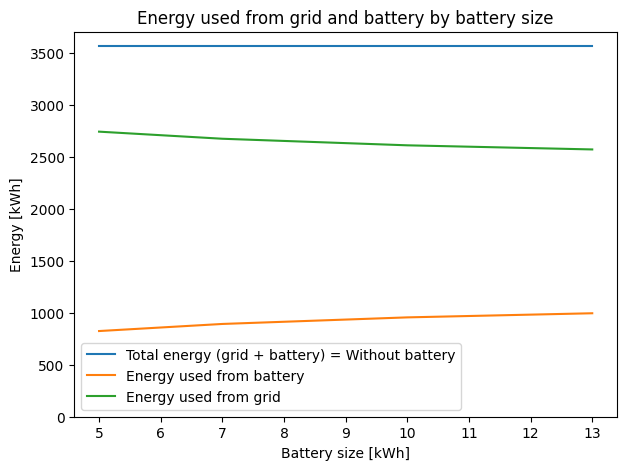

In [77]:
# Plot energy used from grid and from battery for different battery sizes
#plt.style.use('seaborn-ticks') #'seaborn-ticks'
plt.figure(figsize=(7,5))
plt.plot(battery_sizes,total_energy, label = 'Total energy (grid + battery) = Without battery')
plt.plot(battery_sizes,bat_energy, label = 'Energy used from battery')
plt.plot(battery_sizes,grid_energy, label = 'Energy used from grid')

plt.ylim(ymin=0) 
plt.legend()
plt.xlabel("Battery size [kWh]")
plt.ylabel("Energy [kWh]")
plt.title("Energy used from grid and battery by battery size")
plt.show()

## Total Energy used from Battery

In [78]:
# Create list that contains column names of batteries
columns =[]
for bat in battery_names:
    columns.append('total_energy_provided_by_battery_' + bat)#
    
print("Total energy used from battery instead of grid (in kWh):")
# Last line in df contains the total energy (in kWh) that was used from the battery
df.iloc[-1][columns]

Total energy used from battery instead of grid (in kWh):


total_energy_provided_by_battery_5     824.2055
total_energy_provided_by_battery_7      892.429
total_energy_provided_by_battery_10     955.675
total_energy_provided_by_battery_13    995.3015
Name: 35025, dtype: object

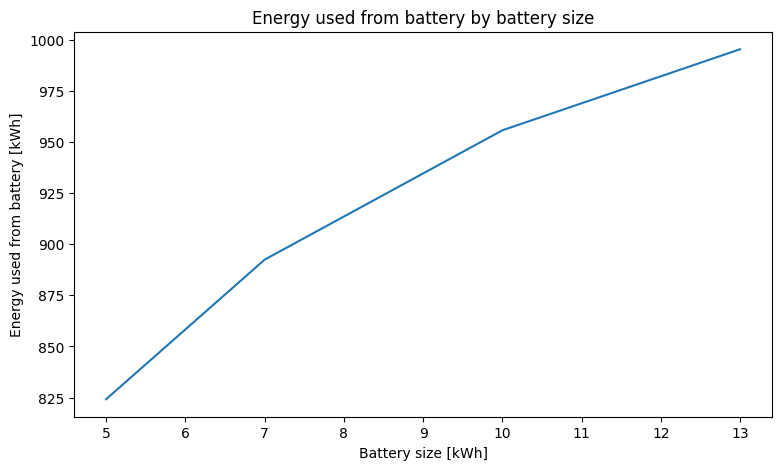

In [79]:
plt.figure(figsize=(9,5))
plt.plot(battery_sizes, df.iloc[-1][columns].tolist(), label = "total_energy_provided_by_battery_" + bat)
plt.xlabel("Battery size [kWh]")
plt.ylabel("Energy used from battery [kWh]")
plt.title("Energy used from battery by battery size")
plt.show()

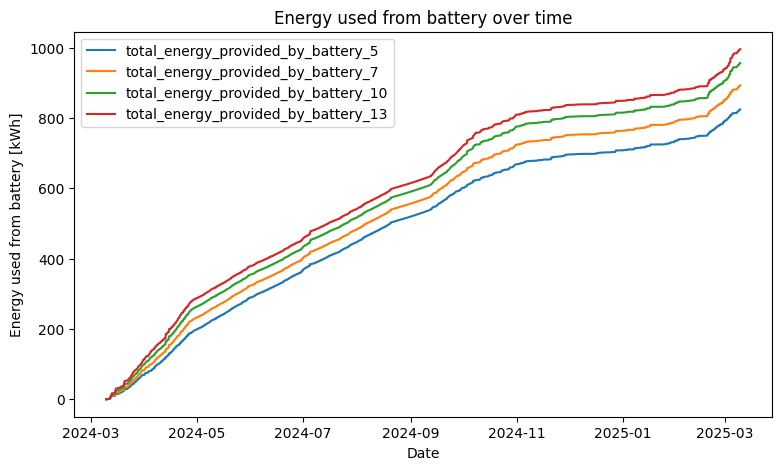

In [80]:
# Plot total energy used by each battery over time
plt.figure(figsize=(9,5))
for bat in battery_names:
    plt.plot(df['time'],df['total_energy_provided_by_battery_' + bat], label = "total_energy_provided_by_battery_" + bat)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Energy used from battery [kWh]")
plt.title("Energy used from battery over time")
plt.show()


## Plot State of Charge for Batteries

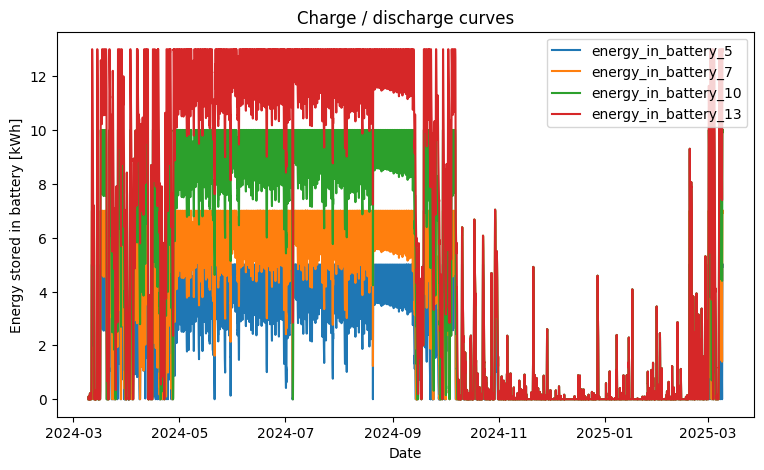

In [81]:
plt.figure(figsize=(9,5))
for i in range(len(battery_names)):
    Ladestatus = df['energy_in_battery_' + battery_names[i]] # / Batterie_Groessen[i] * 100
    plt.plot(df['time'], Ladestatus, label = 'energy_in_battery_' + battery_names[i])
plt.legend()
plt.xlabel("Date")
plt.title("Charge / discharge curves")
plt.ylabel("Energy stored in battery [kWh]")
plt.show()

## Monthly Details

,energy_provided_by_battery_5,energy_provided_by_battery_7,energy_provided_by_battery_10,energy_provided_by_battery_13
label,,,,
2024-3,72.2130,85.9905,101.3015,115.9595
2024-4,126.6525,146.4445,162.1370,171.7830
2024-5,90.4425,90.8260,90.8260,90.8260
2024-6,78.6800,78.6800,78.6800,78.6800
2024-7,78.5835,80.5835,83.5835,83.7395
2024-8,72.6655,73.4320,73.4320,73.4320
2024-9,81.6130,90.3430,100.3760,106.3760
2024-10,67.5625,77.6965,85.2370,88.4035
2024-11,27.7620,27.7620,27.7620,27.7620


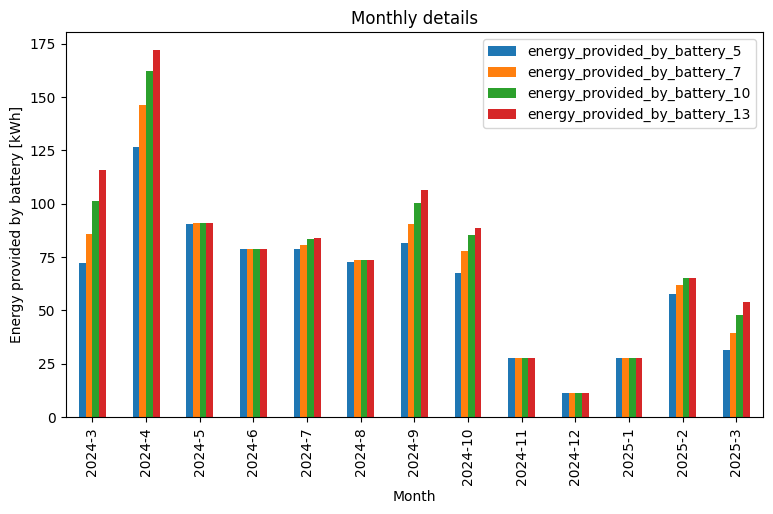

In [82]:
# Used timestamp as index and group results by month
df.index = pd.to_datetime(df['timestamp'], format='ISO8601')
df = df.drop(['timestamp', 'time'], axis=1)

Monatswerte = df.groupby(by=[df.index.year, df.index.month]).sum()
# Monatswerte = df.groupby(pd.Grouper(freq='M')).sum()

# Copy index to new column. Is used afterwards, to create a label of format YYYY-MM
Monatswerte.index = Monatswerte.index.rename(['Year', 'Month'])
Monatswerte = Monatswerte.reset_index(level=[0,1])
Monatswerte['label'] = Monatswerte.Year.astype(str) + '-' + Monatswerte.Month.astype(str)
Monatswerte = Monatswerte.set_index('label')

# Show table containing monthly values
columns =[]
for bat in battery_names:
    columns.append('energy_provided_by_battery_' + bat)#


# Plot monthly values as bar chart
ax = Monatswerte[columns].plot.bar(figsize=(9,5), title='Monthly details')
ax.set_xlabel("Month")
ax.set_ylabel("Energy provided by battery [kWh]")
Monatswerte[columns]



# ToDo:
- check length of time period used to calculate energy. If the sensor was removed, data is missing. This results in a long time period between two measurements. As the energy is calculated by multipling the power with the time period, this can result in a huge step.

- Increase performence by improving simulate_battery(). Try to use vectorization instead of the for loop.

- Allow different values of `max_discharging_power` and `max_charging_power` for each battery.

- Consider losses during charge and discharge.
